<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
This notebook is designed specially for the module

ET5003 - MACHINE LEARNING APPLICATIONS 

Instructor: Enrique Naredo
###ET5003_BayesianNN

© All rights reserved to the author, do not share outside this module.


## Introduction

A [Bayesian network](https://en.wikipedia.org/wiki/Bayesian_network) (also known as a Bayes network, Bayes net, belief network, or decision network) is a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG). 

* Bayesian networks are ideal for taking an event that occurred and predicting the likelihood that any one of several possible known causes was the contributing factor. 
* For example, a Bayesian network could represent the probabilistic relationships between diseases and symptoms. 
* Given symptoms, the network can be used to compute the probabilities of the presence of various diseases.

**Acknowledgement**

This notebook is refurbished taking source code from Alessio Benavoli's webpage and from the libraries numpy, GPy, pylab, and pymc3.

## Libraries

In [1]:
import GPy as GPy
import numpy as np
import pylab as pb
import pymc3 as pm

%load_ext lab_black
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data generation
Generate data from a nonlinear function and use a Gaussian Process to sample it.

In [2]:
# seed the legacy random number generator
# to replicate experiments
seed = 7
np.random.seed(seed)

In [3]:
# Gaussian Processes
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
# Radial Basis Functions
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
# kernel is a function that specifies the degree of similarity
# between variables given their relative positions in parameter space
kernel = GPy.kern.RBF(input_dim=1, lengthscale=0.15, variance=0.2)
print(kernel)

  rbf.         |  value  |  constraints  |  priors
  variance     |    0.2  |      +ve      |        
  lengthscale  |   0.15  |      +ve      |        


In [4]:
def generate_sample_data(
    train_size=250, test_size=200, sample_mean=0.8, sample_var=0.6, kernel=kernel
):
    """Generates sample data between the interval [1-sample_mean, sample_mean-1]"""
    X_train = np.sort(
        np.hstack(
            [
                np.random.rand(int(train_size / 2)) * sample_var - sample_mean,
                np.random.rand(int(train_size / 2)) * sample_var + sample_mean,
            ]
        )
    )
    X_test = np.linspace(-1, 1, test_size)
    X = np.hstack([X_train, X_test]).reshape(-1, 1)

    mu = np.zeros(shape=(len(X)))  # Means
    C = kernel.K(X, X)  # Covariance Matrix
    eps = 0.1  # Noise factor

    y_true = np.random.multivariate_normal(mu, C, size=1)[0, :]
    y_train = y_true[: len(X_train)] + np.random.randn(len(X_train)) * eps
    y_test = y_true[len(X_train) :] + np.random.randn(len(X_test)) * eps

    return (X_train, y_train), (X_test, y_test), y_true

In [5]:
(X_train, y_train), (X_test, y_test), y_true = generate_sample_data()
print(X_train.shape, X_test.shape, y_true.shape)

(250,) (200,) (450,)


In this example, first generate a nonlinear functions and then generate noisy training data from that function.

The constrains are:
* Training samples $x$ belong to either interval $[-0.8,-0.2]$ or $[0.2,0.8]$.
* There is not data training samples from the interval $[-0.2,0.2]$. 
* The goal is to evaluate the extrapolation error outside in the interval  $[-0.2,0.2]$.

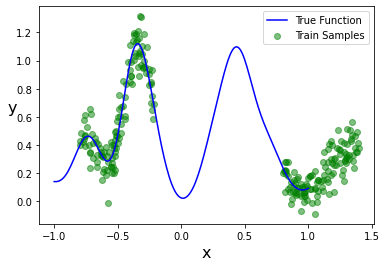

In [6]:
# plot true function
pb.figure()
pb.plot(X_test, y_true[len(X_train) :], c="b", label="True Function", zorder=100)

# training data
pb.scatter(X_train, y_train, c="g", label="Train Samples", alpha=0.5)
pb.xlabel("x", fontsize=16)
pb.ylabel("y", fontsize=16, rotation=0)
pb.legend()

## Bayesian NN
We address the previous nonlinear regression problem by using a Bayesian NN.

**The model is basically very similar to polynomial regression**. We first define the nonlinear function (NN)
and the place a prior over the unknown parameters. We then compute the posterior.

In [9]:
import theano

# add a column of ones to include an intercept in the model (i.e. bias)
X_train_bias = np.vstack([np.ones(len(X_train)), X_train]).T


n_units = 15
# Initialize random weights between each layer
# we do that to help the numerical algorithm that computes the posterior
init_input = np.random.randn(X_train_bias.shape[1], n_units).astype(
    theano.config.floatX
)
init_output = np.random.randn(n_units).astype(theano.config.floatX)

# pymc3 model as neural_network
with pm.Model() as neural_network:
    # we convert the data in theano type so we can do dot products with the correct type.
    inputs = pm.Data("ann_input", X_train_bias)
    targets = pm.Data("ann_output", y_train)

    # Weights from input to hidden layer
    hidden_1 = pm.Normal(
        "hidden_1",
        mu=0,
        sigma=10,
        shape=(X_train_bias.shape[1], n_units),
        testval=init_input,
    )
    activation_1 = pm.math.tanh(
        pm.math.dot(inputs, hidden_1)
    )  # activation for the first layer

    # Inner layer
    # Weights from hidden layer to output
    output_layer = pm.Normal(
        "output_layer", mu=0, sigma=10, shape=(n_units,), testval=init_output
    )
    out_activation = pm.Deterministic(
        "outputs", pm.math.dot(activation_1, output_layer)
    )  # There's no activation

    # standard deviation of noise
    sigma = pm.HalfCauchy("sigma", 5)
    # Normal likelihood
    likelihood = pm.Normal("likelihood", out_activation, sigma=sigma, observed=targets)

In [23]:
# this can be slow because there are many parameters

# some parameters
par1 = 1000  # start with 100, then use 1000+
par2 = 10000  # start with 1000, then use 10000+

# neural network
with neural_network:
    posterior = pm.sample(par1, tune=par2, chains=1)

 ipykernel_launcher:9: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, output_layer, hidden_1]


Sampling 1 chain for 10_000 tune and 1_000 draw iterations (10_000 + 1_000 draws total) took 2047 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.5738092104660254, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


Specifically, PyMC3 supports the following Variational Inference (VI) methods:

  * Automatic Differentiation Variational Inference (ADVI): 'advi'
  * ADVI full rank: 'fullrank_advi'
  * Stein Variational Gradient Descent (SVGD): 'svgd'
  * Amortized Stein Variational Gradient Descent (ASVGD): 'asvgd'
  * Normalizing Flow with default scale-loc flow (NFVI): 'nfvi'


Finished [100%]: Average Loss = 20.658


Text(0.5, 0, 'iteration')

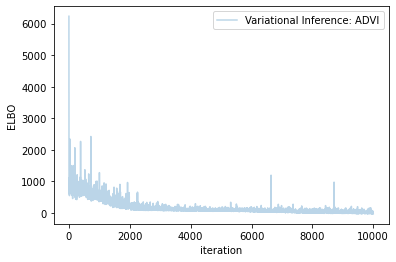

In [24]:
# we can do instead an approximated inference
n_iterations = 10_000  # start with 1000, then use 50000+
method = "advi"  # 'advi', 'fullrank_advi', 'svgd', 'asvgd', 'nfvi'
optimizer = pm.adam  # pm.adam, pm.sgd, pm.adagrad, pm.adagrad_window, pm.adadelta
learning_rate = 0.01

with neural_network:
    approx = pm.fit(
        n_iterations,
        method=method,
        obj_optimizer=optimizer(learning_rate=learning_rate),
    )


# plot
# Evidence Lower Bound (ELBO)
# https://en.wikipedia.org/wiki/Evidence_lower_bound
pb.plot(approx.hist, label="Variational Inference: " + method.upper(), alpha=0.3)
pb.legend(loc="upper right")
pb.ylabel("ELBO")
pb.xlabel("iteration")

In [25]:
# draw samples from variational posterior
posterior_samples = 1_000
posterior = approx.sample(draws=posterior_samples)

Now, we compute the prediction for each sample. 
* Note that we use `np.tanh` instead of `pm.math.tanh`
for speed reason. 
* `pm.math.tanh` is slower outside a Pymc3 model because it converts all data in theano format.
* It is convenient to do GPU-based training, but it is slow when we only need to compute predictions.

In [26]:
# add a column of ones to include an intercept in the model
X_test_bias = np.vstack([np.ones(len(X_test)), X_test]).T

y_pred = []
for i in range(posterior["hidden_1"].shape[0]):
    # inner layer
    h1 = np.tanh(np.dot(posterior["hidden_1"][i, :, :].T, X_test_bias.T))
    # outer layer
    y_pred.append(np.dot(posterior["output_layer"][i, :], h1))

# predictions
y_pred = np.array(y_pred)

We first plot the mean  of `y_pred`, this is very similar to the prediction that Keras returns

Text(0, 0.5, 'y')

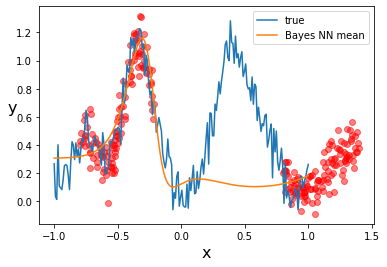

In [27]:
# plot
pb.plot(X_test, y_test, label="true")
pb.plot(X_test, y_pred.mean(axis=0), label="Bayes NN mean")
pb.scatter(X_train, y_train, c="r", alpha=0.5)
pb.legend()
# pb.ylim([-1, 1])
pb.xlabel("x", fontsize=16)
pb.ylabel("y", fontsize=16, rotation=0)

Now, we plot the uncertainty, by plotting N nonlinear regression lines from the posterior

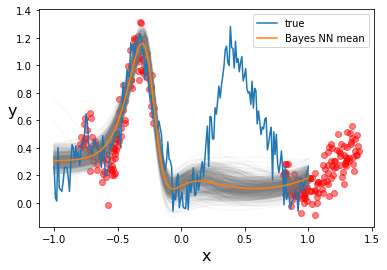

In [28]:
# plot
pb.plot(X_test, y_test, label="true", zorder=100)
pb.plot(X_test, y_pred.mean(axis=0), label="Bayes NN mean", zorder=100)


N = 500
# nonlinear regression lines
for i in range(N):
    pb.plot(X_test, y_pred[i, :], c="gray", alpha=0.05)
pb.scatter(X_train, y_train, c="r", alpha=0.5)

pb.xlabel("x", fontsize=16)
pb.ylabel("y", fontsize=16, rotation=0)
# pb.ylim([-1,1.5])
pb.legend()

Just the same plot again, for some reason

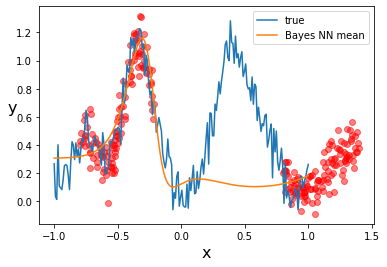

In [29]:
# plot
pb.plot(X_test, y_test, label="true", zorder=100)
pb.plot(X_test, y_pred.mean(axis=0), label="Bayes NN mean", zorder=100)
pb.scatter(X_train, y_train, c="r", alpha=0.5)
pb.xlabel("x", fontsize=16)
pb.ylabel("y", fontsize=16, rotation=0)
# pb.ylim([-1, 1.5])
pb.legend()